In [4]:
import psycopg2

import copy
import random
import numpy as np
import pandas as pd

import joblib
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Subset, DataLoader

from Dataset.Embedding_Dataset import Embedding_Dataset
from Model.Embedding import Embedding

from Dataset.Apartment_Complex_Dataset import Apartment_Complex_Dataset
from Model.LSTM import LSTM
from Model.GRU import GRU
from Model.Transformer import Transformer

from Dataset.District_Dataset import District_Dataset
from Model.LSTM_Attention import LSTMAttention
from Model.GRU_Attention import GRUAttention
from Model.Transformer_Attention import TransformerAttention

from utils import RMSE, rmse, mse, mae, mape, save_train_test_losses

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

table_1 = pd.read_csv('../데이터/Table/table_1.csv') 
table_2 = pd.read_csv('../데이터/Table/table_2.csv') 
table_3 = pd.read_csv('../데이터/Table/table_3.csv') 

In [22]:
table_3['did']

0          0
1          1
2          2
3          3
4          4
        ... 
60364    204
60365    205
60366    210
60367    211
60368    212
Name: did, Length: 60369, dtype: int64

In [2]:
train_ratio = 0.7
test_ratio = 0.3

epochs = 10000
lrs = 1e-4
batches = 256
subs = [True, False]
embedding_dims = [512, 1024, 2048] 
window_sizes = [1, 7, 30]

Embedding	 Epoch [1/10000], Train Loss: 0.955960, Test Loss: 3.812281
Embedding	 Epoch [2/10000], Train Loss: 0.748264, Test Loss: 3.372955
Embedding	 Epoch [3/10000], Train Loss: 0.681079, Test Loss: 3.078740
Embedding	 Epoch [4/10000], Train Loss: 0.646248, Test Loss: 3.070028
Embedding	 Epoch [5/10000], Train Loss: 0.623195, Test Loss: 2.811720
Embedding	 Epoch [6/10000], Train Loss: 0.606986, Test Loss: 3.006784
Embedding	 Epoch [7/10000], Train Loss: 0.596322, Test Loss: 3.083443
Embedding	 Epoch [8/10000], Train Loss: 0.586563, Test Loss: 3.146584 
Early Stop Triggered!
Min Train Loss: 0.5865627824357061
Min Test Loss: 2.811720499755643
Transformer	 Epoch [1/10000], Train Loss: 1.604182, Test Loss: 1.850612
Transformer	 Epoch [2/10000], Train Loss: 1.518761, Test Loss: 1.840345
Transformer	 Epoch [3/10000], Train Loss: 1.521134, Test Loss: 1.843635
Transformer	 Epoch [4/10000], Train Loss: 1.514798, Test Loss: 1.848243
Transformer	 Epoch [5/10000], Train Loss: 1.513887, Test Loss

C:\Users\USER\AppData\Local\Temp\ipykernel_17560\3420303466.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Embedding	 Epoch [1/10000], Train Loss: 0.964914, Test Loss: 4.044018
Embedding	 Epoch [2/10000], Train Loss: 0.754344, Test Loss: 4.373922
Embedding	 Epoch [3/10000], Train Loss: 0.689829, Test Loss: 3.966305
Embedding	 Epoch [4/10000], Train Loss: 0.653211, Test Loss: 3.768061
Embedding	 Epoch [5/10000], Train Loss: 0.633056, Test Loss: 3.855157
Embedding	 Epoch [6/10000], Train Loss: 0.617749, Test Loss: 3.873092
Embedding	 Epoch [7/10000], Train Loss: 0.605196, Test Loss: 3.929432 
Early Stop Triggered!
Min Train Loss: 0.6051961693799857
Min Test Loss: 3.7680614463826445
Transformer	 Epoch [1/10000], Train Loss: 1.594301, Test Loss: 2.104819
Transformer	 Epoch [2/10000], Train Loss: 1.559205, Test Loss: 2.067538
Transformer	 Epoch [3/10000], Train Loss: 1.552741, Test Loss: 2.045520
Transformer	 Epoch [4/10000], Train Loss: 1.547211, Test Loss: 2.041761
Transformer	 Epoch [5/10000], Train Loss: 1.545771, Test Loss: 2.042471
Transformer	 Epoch [6/10000], Train Loss: 1.546221, Test L

C:\Users\USER\AppData\Local\Temp\ipykernel_17560\3420303466.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Embedding	 Epoch [1/10000], Train Loss: 0.918973, Test Loss: 4.862298
Embedding	 Epoch [2/10000], Train Loss: 0.728655, Test Loss: 4.487514
Embedding	 Epoch [3/10000], Train Loss: 0.672528, Test Loss: 4.302554
Embedding	 Epoch [4/10000], Train Loss: 0.640181, Test Loss: 4.159017
Embedding	 Epoch [5/10000], Train Loss: 0.621687, Test Loss: 4.075948
Embedding	 Epoch [6/10000], Train Loss: 0.610254, Test Loss: 4.133104
Embedding	 Epoch [7/10000], Train Loss: 0.598270, Test Loss: 4.129266
Embedding	 Epoch [8/10000], Train Loss: 0.590794, Test Loss: 4.275051 
Early Stop Triggered!
Min Train Loss: 0.5907943549481305
Min Test Loss: 4.075947962754162
Transformer	 Epoch [1/10000], Train Loss: 1.765861, Test Loss: 2.005414
Transformer	 Epoch [2/10000], Train Loss: 1.707474, Test Loss: 1.925884
Transformer	 Epoch [3/10000], Train Loss: 1.707393, Test Loss: 1.848288
Transformer	 Epoch [4/10000], Train Loss: 1.695309, Test Loss: 1.847933
Transformer	 Epoch [5/10000], Train Loss: 1.697474, Test Loss

C:\Users\USER\AppData\Local\Temp\ipykernel_17560\3420303466.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Embedding	 Epoch [1/10000], Train Loss: 0.950351, Test Loss: 4.435568
Embedding	 Epoch [2/10000], Train Loss: 0.744580, Test Loss: 4.224352
Embedding	 Epoch [3/10000], Train Loss: 0.686434, Test Loss: 3.865493
Embedding	 Epoch [4/10000], Train Loss: 0.654174, Test Loss: 3.853646
Embedding	 Epoch [5/10000], Train Loss: 0.633394, Test Loss: 3.885393
Embedding	 Epoch [6/10000], Train Loss: 0.621140, Test Loss: 3.856897
Embedding	 Epoch [7/10000], Train Loss: 0.611072, Test Loss: 3.837061
Embedding	 Epoch [8/10000], Train Loss: 0.603525, Test Loss: 3.891354
Embedding	 Epoch [9/10000], Train Loss: 0.596618, Test Loss: 4.007504
Embedding	 Epoch [10/10000], Train Loss: 0.590406, Test Loss: 4.196214 
Early Stop Triggered!
Min Train Loss: 0.590406030868039
Min Test Loss: 3.8370605616282063
Transformer	 Epoch [1/10000], Train Loss: 1.651732, Test Loss: 1.851031
Transformer	 Epoch [2/10000], Train Loss: 1.521689, Test Loss: 1.835968
Transformer	 Epoch [3/10000], Train Loss: 1.515548, Test Loss: 1

C:\Users\USER\AppData\Local\Temp\ipykernel_17560\3420303466.py:268: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Embedding	 Epoch [1/10000], Train Loss: 0.943838, Test Loss: 4.228469
Embedding	 Epoch [2/10000], Train Loss: 0.743092, Test Loss: 3.843249
Embedding	 Epoch [3/10000], Train Loss: 0.688235, Test Loss: 3.895595
Embedding	 Epoch [4/10000], Train Loss: 0.659332, Test Loss: 3.940623
Embedding	 Epoch [5/10000], Train Loss: 0.634807, Test Loss: 4.117109 
Early Stop Triggered!
Min Train Loss: 0.6348069556734779
Min Test Loss: 3.843248560073528
Transformer	 Epoch [1/10000], Train Loss: 1.784448, Test Loss: 2.182083
Transformer	 Epoch [2/10000], Train Loss: 1.565141, Test Loss: 2.063454
Transformer	 Epoch [3/10000], Train Loss: 1.547348, Test Loss: 2.051444
Transformer	 Epoch [4/10000], Train Loss: 1.547056, Test Loss: 2.049689
Transformer	 Epoch [5/10000], Train Loss: 1.547132, Test Loss: 2.049362
Transformer	 Epoch [6/10000], Train Loss: 1.547156, Test Loss: 2.049280
Transformer	 Epoch [7/10000], Train Loss: 1.547164, Test Loss: 2.049247
Transformer	 Epoch [8/10000], Train Loss: 1.547169, Tes

KeyboardInterrupt: 

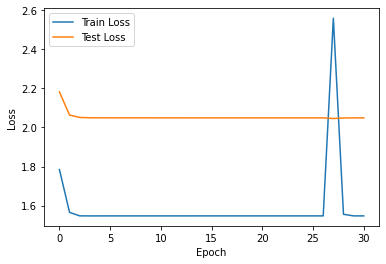

In [3]:
results_df = pd.DataFrame(columns=['sub', 'embedding_dim', 'window_size', 'rmse', 'mse', 'mae', 'mape'])
for batch in batches:
    for sub in subs:
        for embedding_dim in embedding_dims:
            for window_size in window_sizes:
                # embedding
                dataset = Embedding_Dataset(table_1, table_2, table_3)
                dataset_length = len(dataset)
                train_size = int(train_ratio * dataset_length)
                train_indices = range(0, train_size)
                test_size = int(test_ratio * dataset_length)
                test_indices = range(train_size, dataset_length)
                train_dataset = Subset(dataset, train_indices)
                test_dataset = Subset(dataset, test_indices)
                train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, drop_last=True)
                test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)

                embedding_model = Embedding(128, 256, 512, embedding_dim, 512, 256, 128).to(DEVICE)
                criterion = RMSE()
                optimizer = torch.optim.Adam(embedding_model.parameters(), lr=lr)

                embedding_train_losses = []
                embedding_test_losses = []

                max_early_stop_count = 3
                early_stop_count = 0
                embedding_best_test_loss = float('inf')
                embedding_best_model_weights = None

                for epoch in range(epochs):
                    embedding_model.train()
                    embedding_total_train_loss = 0
                    for data in train_dataloader:
                        input = data[0].to(DEVICE)
                        target = data[1].to(DEVICE)
                        output = embedding_model(input).to(DEVICE)

                        embedding_train_loss = criterion(output, target)
                        embedding_total_train_loss += embedding_train_loss.item()

                        optimizer.zero_grad()
                        embedding_train_loss.backward()
                        optimizer.step()

                    embedding_avg_train_loss = embedding_total_train_loss / len(train_dataloader)
                    embedding_train_losses.append(embedding_avg_train_loss)

                    embedding_model.eval()
                    embedding_total_test_loss = 0
                    with torch.no_grad():
                        for data in test_dataloader:
                            input = data[0].to(DEVICE)
                            target = data[1].to(DEVICE)
                            output = embedding_model(input).to(DEVICE)

                            embedding_test_loss = criterion(output, target)
                            embedding_total_test_loss += embedding_test_loss.item()

                    embedding_avg_test_loss = embedding_total_test_loss / len(test_dataloader)
                    embedding_test_losses.append(embedding_avg_test_loss)

                    if  embedding_best_test_loss > embedding_avg_test_loss:
                        embedding_best_test_loss = embedding_avg_test_loss
                        embedding_best_model_weights = copy.deepcopy(embedding_model.state_dict())
                        early_stop_count = 0
                    else:
                        early_stop_count += 1

                    if early_stop_count >= max_early_stop_count:
                        print(f'Embedding\t Epoch [{epoch+1}/{epochs}], Train Loss: {embedding_avg_train_loss:.6f}, Test Loss: {embedding_avg_test_loss:.6f} \nEarly Stop Triggered!')
                        embedding_model.load_state_dict(embedding_best_model_weights)
                        torch.save(embedding_model, f'../데이터/Checkpoint/emb/embedding_lr_{lr}_batch_{batch}_sub_{sub}_ed_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}.pth')
                        break

                    print(f'Embedding\t Epoch [{epoch+1}/{epochs}], Train Loss: {embedding_avg_train_loss:.6f}, Test Loss: {embedding_avg_test_loss:.6f}')
                    
                save_train_test_losses(embedding_train_losses, embedding_test_losses, f'../데이터/Checkpoint/emb/embedding_lr_{lr}_batch_{batch}_sub_{sub}_ed_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}')

                # transformer
                dataset = Apartment_Complex_Dataset(embedding_model, table_1, table_2, table_3, embedding_dim, window_size, 'DL', DEVICE)
                dataset_length = len(dataset)
                train_size = int(train_ratio * dataset_length)
                train_indices = range(0, train_size)
                test_size = int(test_ratio * dataset_length)
                test_indices = range(train_size, dataset_length)
                train_dataset = Subset(dataset, train_indices)
                test_dataset = Subset(dataset, test_indices)
                train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, drop_last=True)
                test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)

                transformer_model = Transformer(embedding_dim, 1, 2, 2).to(DEVICE)
                criterion = RMSE()
                optimizer = torch.optim.Adam(transformer_model.parameters(), lr=lr)

                transformer_train_losses = []
                transformer_test_losses = []

                max_early_stop_count = 3
                early_stop_count = 0
                transformer_best_test_loss = float('inf')
                transformer_best_model_weights = None

                for epoch in range(epochs):
                    transformer_model.train()
                    transformer_total_train_loss = 0
                    for data in train_dataloader:
                        src = data[0].to(DEVICE)
                        trg = data[1].to(DEVICE)

                        if (trg[0] != 0):
                            src_mask = transformer_model.generate_square_subsequent_mask(src.shape[1]).to(src.device)
                            output = transformer_model(src, src_mask)

                            transformer_train_loss = criterion(output[0], trg)
                            transformer_total_train_loss += transformer_train_loss.item()

                            optimizer.zero_grad()
                            transformer_train_loss.backward()
                            optimizer.step()
                            
                    transformer_avg_train_loss = transformer_total_train_loss / len(train_dataloader)
                    transformer_train_losses.append(transformer_avg_train_loss)

                    transformer_model.eval()
                    transformer_total_test_loss = 0
                    with torch.no_grad():
                        for data in test_dataloader:
                            src = data[0].to(DEVICE)
                            trg = data[1].to(DEVICE)

                            if (trg[0] != 0):
                                src_mask = transformer_model.generate_square_subsequent_mask(src.shape[1]).to(src.device)
                                output = transformer_model(src, src_mask)

                                transformer_test_loss = criterion(output[0], trg)
                                transformer_total_test_loss += transformer_test_loss.item()

                    transformer_avg_test_loss = transformer_total_test_loss / len(test_dataloader)
                    transformer_test_losses.append(transformer_avg_test_loss)

                    if  transformer_best_test_loss > transformer_avg_test_loss:
                        transformer_best_test_loss = transformer_avg_test_loss
                        transformer_best_model_weights = copy.deepcopy(transformer_model.state_dict())
                        early_stop_count = 0
                    else:
                        early_stop_count += 1
                        
                    if early_stop_count >= max_early_stop_count:
                        print(f'Transformer\t Epoch [{epoch+1}/{epochs}], Train Loss: {transformer_avg_train_loss:.6f}, Test Loss: {transformer_avg_test_loss:.6f} \nEarly Stop Triggered!')
                        transformer_model.load_state_dict(transformer_best_model_weights)
                        torch.save(transformer_model, f'../데이터/Checkpoint/transformer/transformer_lr_{lr}_batch_{batch}_sub_{sub}_ed_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}.pth')
                        break

                    print(f'Transformer\t Epoch [{epoch+1}/{epochs}], Train Loss: {transformer_avg_train_loss:.6f}, Test Loss: {transformer_avg_test_loss:.6f}')
                
                save_train_test_losses(transformer_train_losses, transformer_test_losses, f'../데이터/Checkpoint/transformer/transformer_lr_{lr}_batch_{batch}_sub_{sub}_ed_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}')

                # attention
                dataset = District_Dataset(embedding_model, table_1, table_2, table_3, embedding_dim, window_size, sub, DEVICE)
                dataset_length = len(dataset)
                train_size = int(train_ratio * dataset_length)
                train_indices = range(0, train_size)
                test_size = int(test_ratio * dataset_length)
                test_indices = range(train_size, dataset_length)
                train_dataset = Subset(dataset, train_indices)
                test_dataset = Subset(dataset, test_indices)
                train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, drop_last=True)
                test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)

                transformer_att_model = TransformerAttention(transformer_model, embedding_dim, 1, DEVICE).to(DEVICE)
                criterion = RMSE()
                optimizer = torch.optim.Adam(transformer_att_model.parameters(), lr=lr)

                transformer_att_train_losses = []
                transformer_att_test_rmses = []
                transformer_att_test_mses = []
                transformer_att_test_maes = []
                transformer_att_test_mapes = []

                max_early_stop_count = 3
                early_stop_count = 0
                transformer_att_best_test_rmse = float('inf')
                transformer_att_best_model_weights = None

                for epoch in range(epoch):
                    transformer_att_model.train()
                    transformer_att_total_train_loss = 0
                    for data in train_dataloader:
                        src = data[0][0].to(DEVICE)
                        max_len = data[1][0].to(DEVICE)
                        anw = data[2][0].to(DEVICE)
                        trg = data[3][0].to(DEVICE)
                        
                        if len(anw)==0:
                            continue

                        for index in anw:
                            output = transformer_att_model(src, index, max_len)
                            
                            transformer_att_train_loss = criterion(output, trg[index])
                            transformer_att_total_train_loss += transformer_att_train_loss.item()
                            
                            optimizer.zero_grad()
                            transformer_att_train_loss.backward()
                            optimizer.step() 
                            
                    transformer_att_avg_train_loss = transformer_att_total_train_loss / len(train_dataloader)
                    transformer_att_train_losses.append(transformer_att_avg_train_loss)

                    transformer_att_model.eval()
                    transformer_att_total_test_rmse = 0
                    transformer_att_total_test_mse = 0
                    transformer_att_total_test_mae = 0
                    transformer_att_total_test_mape = 0
                    with torch.no_grad():
                        for data in test_dataloader:
                            src = data[0][0].to(DEVICE)
                            max_len = data[1][0].to(DEVICE)
                            anw = data[2][0].to(DEVICE)
                            trg = data[3][0].to(DEVICE)

                            if len(anw)==0:
                                continue

                            for index in anw:
                                output = transformer_att_model(src, index, max_len)

                                transformer_att_test_rmse = rmse(output, trg[index])
                                transformer_att_test_mse = mse(output, trg[index])
                                transformer_att_test_mae = mae(output, trg[index])
                                transformer_att_test_mape = mape(output, trg[index])
                                
                                transformer_att_total_test_rmse += transformer_att_test_rmse.item()
                                transformer_att_total_test_mse += transformer_att_test_mse.item()
                                transformer_att_total_test_mae += transformer_att_test_mae.item()
                                transformer_att_total_test_mape += transformer_att_test_mape.item()
                                
                    transformer_att_avg_test_rmse = transformer_att_total_test_rmse / len(test_dataloader)
                    transformer_att_avg_test_mse = transformer_att_total_test_mse / len(test_dataloader)
                    transformer_att_avg_test_mae = transformer_att_total_test_mae / len(test_dataloader)
                    transformer_att_avg_test_mape = transformer_att_total_test_mape / len(test_dataloader)
                    transformer_att_test_rmses.append(transformer_att_avg_test_rmse)
                    transformer_att_test_mses.append(transformer_att_avg_test_mse)
                    transformer_att_test_maes.append(transformer_att_avg_test_mae)
                    transformer_att_test_mapes.append(transformer_att_avg_test_mape)
                            
                    if  transformer_att_best_test_rmse > transformer_att_avg_test_rmse:
                        transformer_att_best_test_rmse = transformer_att_avg_test_rmse
                        transformer_att_best_model_weights = copy.deepcopy(transformer_att_model.state_dict())
                        early_stop_count = 0
                    else:
                        early_stop_count += 1

                    if early_stop_count >= max_early_stop_count:
                        print(f'Attention\t Epoch [{epoch+1}/{epochs}], Train Loss: {transformer_att_avg_train_loss:.6f}, Test Loss: {transformer_att_avg_test_rmse:.6f} \nEarly Stop Triggered!')
                        transformer_att_model.load_state_dict(transformer_att_best_model_weights)
                        torch.save(transformer_att_model, f'../데이터/Checkpoint/attention/attention_lr_{lr}_batch_{batch}_sub_{sub}_ed_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}.pth')
                        break

                    print(f'Attention\t Epoch [{epoch+1}/{epochs}], Train Loss: {transformer_att_avg_train_loss:.6f}, Test Loss: {transformer_att_avg_test_rmse:.6f}')

                save_train_test_losses(transformer_att_train_losses, transformer_att_test_rmses, f'../데이터/Checkpoint/attention/attention_rmse_lr_{lr}_batch_{batch}_sub_{sub}_ed_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}')
                save_train_test_losses(transformer_att_train_losses, transformer_att_test_mses, f'../데이터/Checkpoint/attention/attention_mse_lr_{lr}_batch_{batch}_sub_{sub}_ed_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}')
                save_train_test_losses(transformer_att_train_losses, transformer_att_test_maes, f'../데이터/Checkpoint/attention/attention_mae_lr_{lr}_batch_{batch}_sub_{sub}_ed_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}')
                save_train_test_losses(transformer_att_train_losses, transformer_att_test_mapes, f'../데이터/Checkpoint/attention/attention_mape_lr_{lr}_batch_{batch}_sub_{sub}_ed_{embedding_dim}_ws_{window_size}_epochs_{epoch+1}')

                results_df = results_df.append({
                    'lr': lr,
                    'batch': batch,
                    'sub': sub,
                    'embedding_dim': embedding_dim,
                    'window_size': window_size,
                    'rmse': min(transformer_att_test_rmses),
                    'mse': min(transformer_att_test_mses),
                    'mae': min(transformer_att_test_maes),
                    'mape': min(transformer_att_test_mapes)
                }, ignore_index=True)

results_df.to_excel('../데이터/Checkpoint/experiment_results.xlsx')